<a href="https://colab.research.google.com/github/aylaIssi/Machine-Learning/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Diabetes Prediction with Logistic Regression**

## **İş Problemi:**

Özellikleri belirtildiğinde kişilerin diyabet hastası olup
olmadıklarını tahmin edebilecek bir makine öğrenmesi
modeli geliştirebilir misiniz?

Veri seti ABD'deki Ulusal Diyabet-Sindirim-Böbrek Hastalıkları Enstitüleri'nde tutulan büyük veri setinin parçasıdır. ABD'deki Arizona Eyaleti'nin en büyük 5. şehri olan Phoenix şehrinde yaşayan 21 yaş ve üzerinde olan Pima Indian kadınları üzerinde yapılan diyabet araştırması için kullanılan verilerdir. 768 gözlem ve 8 sayısal bağımsız değişkenden oluşmaktadır. Hedef değişken "outcome" olarak belirtilmiş olup; 1 diyabet test sonucunun pozitif oluşunu, 0 ise negatif oluşunu belirtmektedir.


**Değişkenler**

**Pregnancies:** Hamilelik sayısı

**Glucose**: Glikoz.

**BloodPressure:** Kan basıncı.

**SkinThickness:** Cilt Kalınlığı

**Insulin:** İnsülin.

**BMI:** Beden kitle indeksi.

**DiabetesPedigreeFunction:** Soyumuzdaki kişilere göre diyabet olma ihtimalimizi hesaplayan bir fonksiyon.

**Age:** Yaş (yıl)

**Outcome:** Kişinin diyabet olup olmadığı bilgisi. Hastalığa sahip (1) ya da değil (0)




1. Exploratory Data Analysis
2. Data Preprocessing
3. Model & Prediction
4. Model Evaluation
5. Model Validation: Holdout
6. Model Validation: 10-Fold Cross Validation
7. Prediction for A New Observation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, plot_roc_curve
from sklearn.model_selection import train_test_split, cross_validate

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.width', 500)


## **Exploratory Data Analysis**

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/DS_Notlar/machine_learning/datasets/diabetes.csv")

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


## **Target'ın Analizi**

In [ ]:
df["Outcome"].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

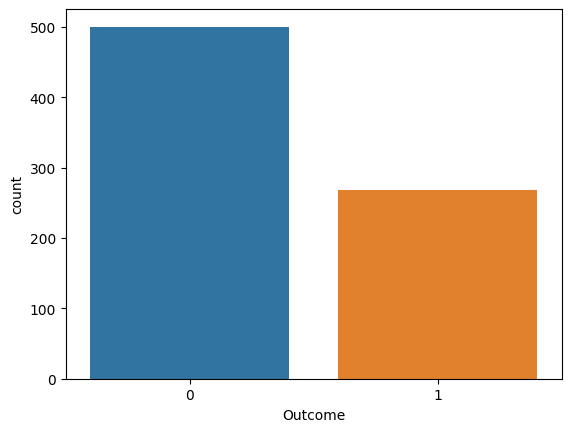

In [ ]:
sns.countplot(x="Outcome", data=df)
plt.show()

In [ ]:
100 * df["Outcome"].value_counts() / len(df)

0   65.104
1   34.896
Name: Outcome, dtype: float64

## **Feature'ların Analizi**

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


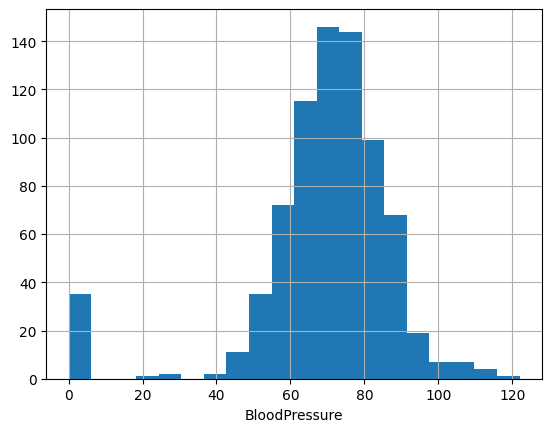

In [ ]:
df["BloodPressure"].hist(bins=20)
plt.xlabel("BloodPressure")
plt.show()

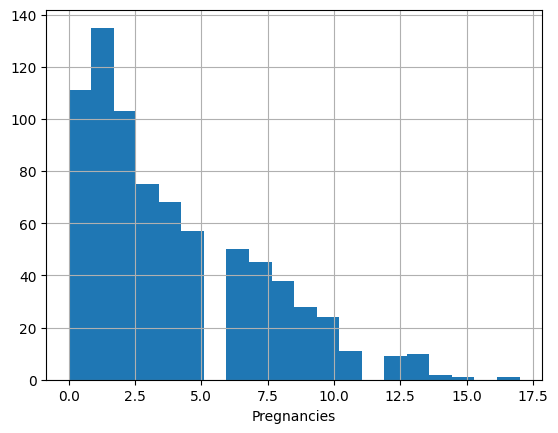

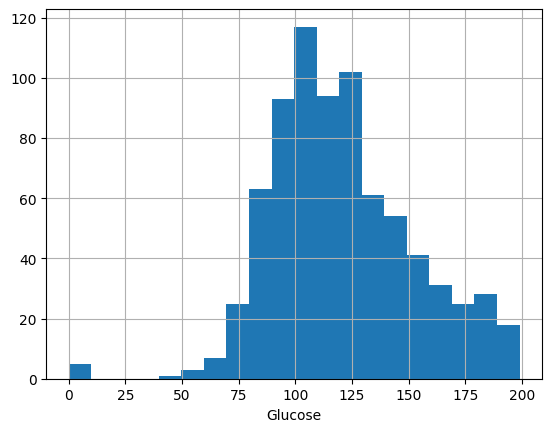

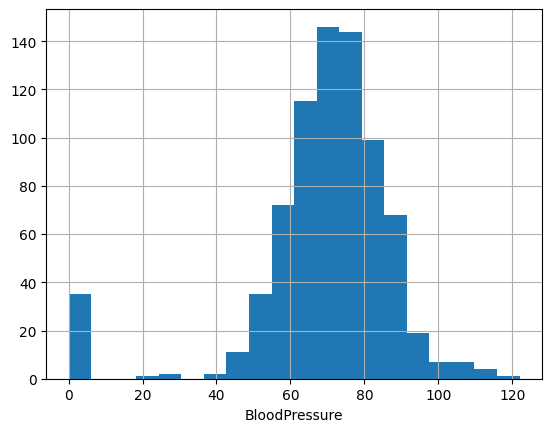

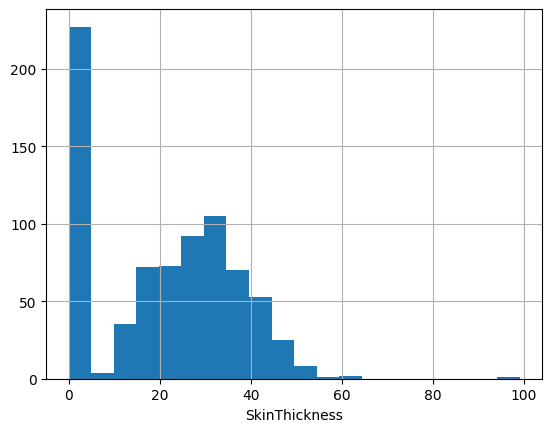

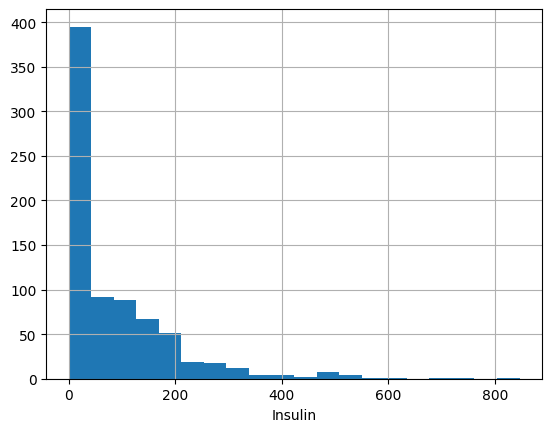

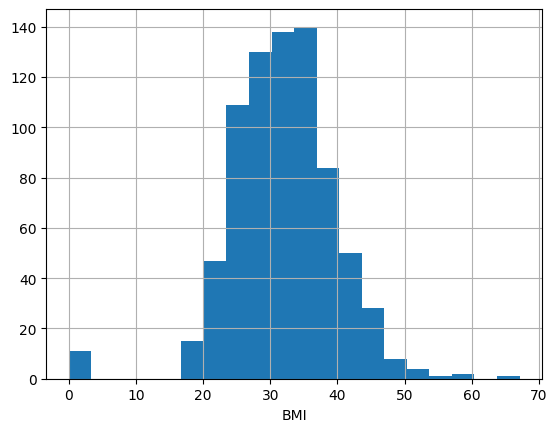

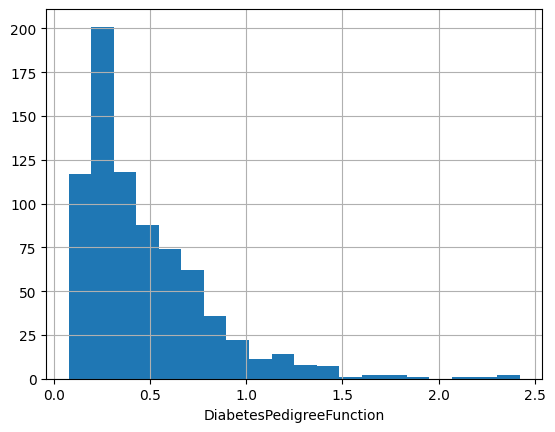

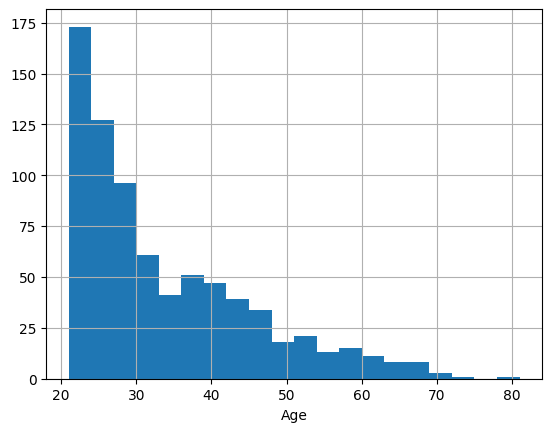

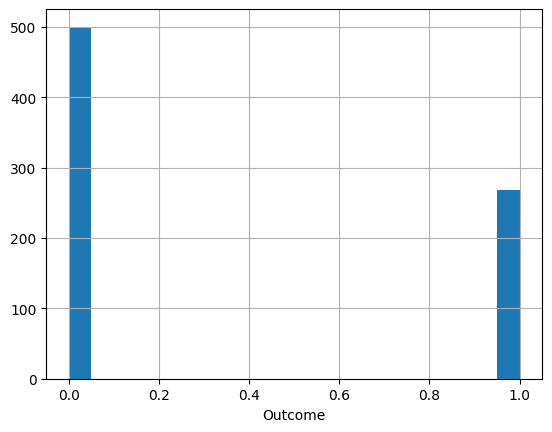

In [ ]:
def plot_numerical_col(dataframe, numerical_col):
    dataframe[numerical_col].hist(bins=20)
    plt.xlabel(numerical_col)
    plt.show(block=True)


for col in df.columns:
    plot_numerical_col(df, col)

cols = [col for col in df.columns if "Outcome" not in col]


# for col in cols:
#     plot_numerical_col(df, col)

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


## **Target vs Features**

In [ ]:
df.groupby("Outcome").agg({"Pregnancies": "mean"})

def target_summary_with_num(dataframe, target, numerical_col):
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

for col in cols:
    target_summary_with_num(df, "Outcome", col)

         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




## **Data Preprocessing (Veri Ön İşleme)**

In [ ]:
df.shape

(768, 9)

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.600,0.627,50,1
1,1,85,66,29,0,26.600,0.351,31,0
2,8,183,64,0,0,23.300,0.672,32,1
3,1,89,66,23,94,28.100,0.167,21,0
4,0,137,40,35,168,43.100,2.288,33,1


In [ ]:
df.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.000,3.845,3.370,0.000,1.000,3.000,6.000,17.000
Glucose,768.000,120.895,31.973,0.000,99.000,117.000,140.250,199.000
BloodPressure,768.000,69.105,19.356,0.000,62.000,72.000,80.000,122.000
SkinThickness,768.000,20.536,15.952,0.000,0.000,23.000,32.000,99.000
Insulin,768.000,79.799,115.244,0.000,0.000,30.500,127.250,846.000
BMI,768.000,31.993,7.884,0.000,27.300,32.000,36.600,67.100
DiabetesPedigreeFunction,768.000,0.472,0.331,0.078,0.244,0.372,0.626,2.420
Age,768.000,33.241,11.760,21.000,24.000,29.000,41.000,81.000
Outcome,768.000,0.349,0.477,0.000,0.000,0.000,1.000,1.000


In [ ]:
for col in cols:
    print(col, check_outlier(df, col))

replace_with_thresholds(df, "Insulin")

for col in cols:
    df[col] = RobustScaler().fit_transform(df[[col]])

df.head()

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.600,0.752,0.000,0.375,-0.240,0.172,0.665,1.235,1
1,-0.400,-0.776,-0.333,0.188,-0.240,-0.581,-0.056,0.118,0
2,1.000,1.600,-0.444,-0.719,-0.240,-0.935,0.783,0.176,1
3,-0.400,-0.679,-0.333,0.000,0.499,-0.419,-0.537,-0.471,0
4,-0.600,0.485,-1.778,0.375,1.081,1.194,5.008,0.235,1


## **Model & Prediction**

In [ ]:
y = df["Outcome"]

X = df.drop(["Outcome"], axis=1)

In [ ]:
log_model = LogisticRegression().fit(X, y)

In [ ]:
log_model.intercept_
log_model.coef_

array([[ 0.59906785,  1.41770936, -0.23152362,  0.01973855, -0.14571255,
         0.81741997,  0.35522795,  0.25655154]])

In [ ]:
y_pred = log_model.predict(X)

In [ ]:
y_pred[0:10]

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0])

In [ ]:
y[0:10]

0    1
1    0
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    1
Name: Outcome, dtype: int64

## **Model & Prediction**

In [ ]:
y = df["Outcome"]

X = df.drop(["Outcome"], axis=1)

In [ ]:
log_model = LogisticRegression().fit(X, y)
log_model.intercept_
log_model.coef_

array([[ 0.59906785,  1.41770936, -0.23152362,  0.01973855, -0.14571255,
         0.81741997,  0.35522795,  0.25655154]])

In [ ]:
y_pred = log_model.predict(X)
y_pred[0:10]

array([1, 0, 1, 0, 1, 0, 0, 1, 1, 0])

In [ ]:
y[0:10]

0    1
1    0
2    1
3    0
4    1
5    0
6    1
7    0
8    1
9    1
Name: Outcome, dtype: int64

## **Model Evaluation**

In [ ]:
def plot_confusion_matrix(y, y_pred):
    acc = round(accuracy_score(y, y_pred), 2)
    cm = confusion_matrix(y, y_pred)
    sns.heatmap(cm, annot=True, fmt=".0f")
    plt.xlabel('y_pred')
    plt.ylabel('y')
    plt.title('Accuracy Score: {0}'.format(acc), size=10)
    plt.show()

plot_confusion_matrix(y, y_pred)

print(classification_report(y, y_pred))

In [ ]:
# ROC AUC
y_prob = log_model.predict_proba(X)[:, 1]
roc_auc_score(y, y_prob)

## **Model Validation: Holdout**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.20, random_state=17)

In [ ]:
log_model = LogisticRegression().fit(X_train, y_train)

In [ ]:
y_pred = log_model.predict(X_test)
y_prob = log_model.predict_proba(X_test)[:, 1]

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
plot_roc_curve(log_model, X_test, y_test)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'r--')
plt.show()

In [ ]:
# AUC
roc_auc_score(y_test, y_prob)

## **Model Validation: 10-Fold Cross Validation**

In [ ]:
y = df["Outcome"]
X = df.drop(["Outcome"], axis=1)

In [ ]:
log_model = LogisticRegression().fit(X, y)

In [ ]:
cv_results = cross_validate(log_model,
                            X, y,
                            cv=5,
                            scoring=["accuracy", "precision", "recall", "f1", "roc_auc"])

In [ ]:
cv_results['test_accuracy'].mean()

In [ ]:
cv_results['test_precision'].mean()

In [ ]:
cv_results['test_recall'].mean()

In [ ]:
cv_results['test_f1'].mean()

In [ ]:
cv_results['test_roc_auc'].mean()

## **Prediction for A New Observation**

In [ ]:
X.columns

random_user = X.sample(1, random_state=45)
log_model.predict(random_user)